In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import tensorflow_probability as tfp

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1740211717.356269  153958 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740211717.359897  153958 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1740211719.465197  153958 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3844 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

# Simulação

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

i_valid_train = pd.Series(train_labels).isin([0,1,2,3,4]).to_numpy()
i_valid_test = pd.Series(test_labels).isin([0,1,2,3,4]).to_numpy()

# Filters to take only the images with labels in [0, 1, 2, 3, 4]
train_images = train_images[i_valid_train]
train_images = train_images / np.max(train_images)
train_shape = train_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
train_images = np.reshape(train_images, (train_shape[0], train_shape[1], train_shape[2], 1))

test_images = test_images[i_valid_test]
test_images = test_images / np.max(test_images)
test_shape = test_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
test_images = np.reshape(test_images, (test_shape[0], test_shape[1], test_shape[2], 1))

train_labels = train_labels[i_valid_train]
test_labels = test_labels[i_valid_test]

In [3]:
def load_file(data_dir, file_index, distribution, train_images, test_images):
    '''
        Example:
            data_dir = "SimulationDataset/Scenario1/n500"
            file_index = 20
            distribution = "poisson"
    '''
    index_path = "{}/indices_{}.csv".format(data_dir, file_index, distribution)
    data_path = "{}/{}/data_{}.csv".format(data_dir, distribution, file_index)
    df_index = pd.read_csv(index_path)
    df_data = pd.read_csv(data_path)

    index_train = df_index.loc[df_index.set == "train","index"].to_numpy()
    index_val = df_index.loc[df_index.set == "val","index"].to_numpy()
    index_test = df_index.loc[df_index.set == "test","index"].to_numpy()

    # Values for the thetas
    theta_train = df_data.loc[df_data.set == "train", "theta"]
    theta_val = df_data.loc[df_data.set == "val", "theta"]
    theta_test = df_data.loc[df_data.set == "test", "theta"]
    # Values for the latent variable
    m_train = df_data.loc[df_data.set == "train", "m"]
    m_val = df_data.loc[df_data.set == "val", "m"]
    m_test = df_data.loc[df_data.set == "test", "m"]
    # Values for the time variable
    t_train = df_data.loc[df_data.set == "train", "t"]
    t_val = df_data.loc[df_data.set == "val", "t"]
    t_test = df_data.loc[df_data.set == "test", "t"]
    # Values for the censorship indicators
    delta_train = df_data.loc[df_data.set == "train", "delta"]
    delta_val = df_data.loc[df_data.set == "val", "delta"]
    delta_test = df_data.loc[df_data.set == "test", "delta"]

    img_train = train_images[index_train,:,:]
    img_val = train_images[index_val,:,:]
    img_test = test_images[index_test,:,:]

    result = {
        "theta_train": theta_train, "theta_val": theta_val, "theta_test": theta_test,
        "m_train": m_train, "m_val": m_val, "m_test": m_test,
        "t_train": t_train, "t_val": t_val, "t_test": t_test,
        "delta_train": delta_train, "delta_val": delta_val, "delta_test": delta_test,
        "img_train": img_train, "img_val": img_val, "img_test": img_test,
        "index_train": index_train, "index_val": index_val, "index_test": index_test
    }
    
    return result

In [4]:
import os, shutil
from pathlib import Path

print("Creating directories structure")
dists_scenario1 = ["poisson", "logarithmic", "geometric", "mvnb2", "bernoulli", "bin5"]
dists_scenario2 = ["borel", "rgp2", "rgp10", "haight", "geeta3"]
for dist in dists_scenario1:
    Path("SimulationResults/Scenario1/n500/{}".format(dist)).mkdir(parents=True, exist_ok=True)
    Path("SimulationResults/Scenario1/n1000/{}".format(dist)).mkdir(parents=True, exist_ok=True)
    Path("SimulationResults/Scenario1/n3000/{}".format(dist)).mkdir(parents=True, exist_ok=True)
for dist in dists_scenario2:
    Path("SimulationResults/Scenario2/n500/{}".format(dist)).mkdir(parents=True, exist_ok=True)
    Path("SimulationResults/Scenario2/n1000/{}".format(dist)).mkdir(parents=True, exist_ok=True)
    Path("SimulationResults/Scenario2/n3000/{}".format(dist)).mkdir(parents=True, exist_ok=True)

Creating directories structure


In [5]:
def fit_cure_model(distribution, q,
                   t_train, t_val,
                   delta_train, delta_val,
                   img_train, img_val,
                   batch_size = None,
                   seed = 1):
    set_all_seeds(seed)
    
    alpha0, s_t = initialize_alpha_s(t_train, n_cuts = 5)
    
    if(distribution == "poisson"):      
        log_a_str = log_a_poisson_str
        log_phi_str = log_phi_poisson_str
        C_str = C_poisson_str
        C_inv_str = C_inv_poisson_str
        sup_str = sup_poisson_str
        theta_min = None
        theta_max = None
    elif(distribution == "logarithmic"):
        log_a_str = log_a_log_str
        log_phi_str = log_phi_log_str
        C_str = C_log_str
        C_inv_str = C_inv_log_str
        sup_str = sup_log_str
        theta_min = 0
        theta_max = 1
    elif(distribution == "nb" or distribution == "mvnb"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "geometric"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "binomial"): 
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "bernoulli"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "rgp"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "borel"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "geeta"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "haight"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(2, dtype = tf.float64)"
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = 1/2

    print(sup_str)
    
    # Because it only serves to initialize the model weights, the distribution does not matter in this case (that's why we use the Poisson here)
    mps_model = MPScrModel(log_a_poisson_tf, log_phi_poisson_tf, C_poisson_tf, C_inv_poisson_tf, sup_poisson)
    mps_model.define_structure(shape_input = img_train[0].shape)

    # If batch_size is null, use just one big batch
    if(batch_size is None):
        batch_size = len(t_train)
    
    results = call_EM("EM.py",
                      log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max,
                      mps_model, alpha0, s_t,
                      img_train, t_train, delta_train, delta_train,
                      max_iterations = 60,
                      early_stopping_em = True, early_stopping_em_warmup = 5, early_stopping_em_eps = 1.0e-6,
                      epochs = 100, batch_size = 64, shuffle = True,
                      learning_rate = 0.001, run_eagerly = True,
                      early_stopping_nn = True, early_stopping_min_delta_nn = 0.0, early_stopping_patience_nn = 5,
                      reduce_lr = True, reduce_lr_steps = 10, reduce_lr_factor = 0.1,
                      validation = True,
                      x_val = img_val, t_val = t_val, delta_val = delta_val, m_val = delta_val,
                      verbose = 3, alpha_known = False)
    return results

In [29]:
file_info = load_file("SimulationDataset/Scenario2/n1000/", 1, "borel", train_images, test_images)
print( "Keys: {}".format(list(file_info.keys())) )

Keys: ['theta_train', 'theta_val', 'theta_test', 'm_train', 'm_val', 'm_test', 't_train', 't_val', 't_test', 'delta_train', 'delta_val', 'delta_test', 'img_train', 'img_val', 'img_test', 'index_train', 'index_val', 'index_test']


In [12]:
alpha0, s_t = initialize_alpha_s(file_info["t_train"], n_cuts = 5)

In [13]:
set_all_seeds(10)

sim_results = fit_cure_model("borel", None,
               file_info["t_train"], file_info["t_val"],
               file_info["delta_train"], file_info["delta_val"],
               file_info["img_train"], file_info["img_val"],
               batch_size = 64,
               seed = 1)

sup_rgp(tf.constant(1, dtype = tf.float64))


/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1740212330.904879  161502 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740212330.908638  161502 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1740212334.245944  161502 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3676 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1740212334.2741

Iniciando passo 1


 36%|███▌      | 36/100 [00:26<00:46,  1.36epoch/s, loss=1.18, loss_val=1.12] 


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 0.00047711968912985347
Distância Parâmetros Alpha: 0.6992395577006051
Média das distâncias: 0.3498583386948675
Iniciando passo 2


 16%|█▌        | 16/100 [00:10<00:52,  1.59epoch/s, loss=1.59, loss_val=1.71]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 8.186887584370783e-05
Distância Parâmetros Alpha: 0.18224067054401757
Média das distâncias: 0.09116126970993065
Iniciando passo 3


  9%|▉         | 9/100 [00:05<00:59,  1.54epoch/s, loss=2.6, loss_val=2.24] 


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.433781360803244e-05
Distância Parâmetros Alpha: 0.03864966091888405
Média das distâncias: 0.01933199936624604
Iniciando passo 4


  8%|▊         | 8/100 [00:05<01:05,  1.39epoch/s, loss=3.24, loss_val=0.0249] 


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 5.604349357030808e-06
Distância Parâmetros Alpha: 0.019156680286314256
Média das distâncias: 0.009581142317835644
Iniciando passo 5


  7%|▋         | 7/100 [00:04<01:01,  1.51epoch/s, loss=4.23, loss_val=3.44]     


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 8.369272048882198e-06
Distância Parâmetros Alpha: 0.00612134136651318
Média das distâncias: 0.003064855319281031
Iniciando passo 6


  7%|▋         | 7/100 [00:04<01:01,  1.52epoch/s, loss=0.0209, loss_val=0.00964]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 8.606345376074543e-06
Distância Parâmetros Alpha: 0.0026169733752803887
Média das distâncias: 0.0013127898603282316
Iniciando passo 7


  8%|▊         | 8/100 [00:05<01:02,  1.47epoch/s, loss=2.83, loss_val=0.00802]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 8.821835279097234e-06
Distância Parâmetros Alpha: 0.0015918610789345865
Média das distâncias: 0.0008003414571068418
Iniciando passo 8


  6%|▌         | 6/100 [00:03<00:59,  1.57epoch/s, loss=3.35, loss_val=0.0275]  


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 6.552224517105339e-06
Distância Parâmetros Alpha: 0.0008352495800619339
Média das distâncias: 0.0004209009022895196
Iniciando passo 9


 17%|█▋        | 17/100 [00:11<00:58,  1.42epoch/s, loss=9.2, loss_val=5.34]     


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.7272186521269813e-05
Distância Parâmetros Alpha: 0.001880132413155217
Média das distâncias: 0.0009537022998382434
Iniciando passo 10


 14%|█▍        | 14/100 [00:08<00:51,  1.68epoch/s, loss=3.25, loss_val=0.0167]  


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.709500587157463e-05
Distância Parâmetros Alpha: 0.0006540366840909118
Média das distâncias: 0.00033556584498124325
Learning rate reduzida para 0.0001
Iniciando passo 11


  6%|▌         | 6/100 [00:03<01:00,  1.56epoch/s, loss=6.42, loss_val=0.0164]   


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.9482991006664664e-07
Distância Parâmetros Alpha: 0.0002702918490974661
Média das distâncias: 0.00013524333950376636
Iniciando passo 12


  6%|▌         | 6/100 [00:03<01:00,  1.55epoch/s, loss=9.66, loss_val=0.0163]  


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.2667679731429488e-07
Distância Parâmetros Alpha: 0.0002244571232517902
Média das distâncias: 0.00011229190002455225
Iniciando passo 13


  6%|▌         | 6/100 [00:03<00:58,  1.60epoch/s, loss=7.95, loss_val=0.0223]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 7.527176312680995e-08
Distância Parâmetros Alpha: 8.426035394645363e-05
Média das distâncias: 4.216781285479022e-05
Iniciando passo 14


  0%|          | 0/100 [00:00<?, ?epoch/s]

Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.8544149674515433e-07
Distância Parâmetros Alpha: 9.444720015753075e-05
Média das distâncias: 4.7416320827137956e-05
Iniciando passo 15


 11%|█         | 11/100 [00:06<00:55,  1.60epoch/s, loss=0.0411, loss_val=0.0308]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 6.010590765192321e-07
Distância Parâmetros Alpha: 7.674014615683463e-06
Média das distâncias: 4.137536846101347e-06
Iniciando passo 16


 13%|█▎        | 13/100 [00:07<00:53,  1.64epoch/s, loss=7.84, loss_val=0.0299] 


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 9.953906376576991e-07
Distância Parâmetros Alpha: 2.4228579064680426e-06
Média das distâncias: 1.7091242720628708e-06
Iniciando passo 17


 11%|█         | 11/100 [00:06<00:55,  1.61epoch/s, loss=0.0188, loss_val=0.0458]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.8961400628848807e-07
Distância Parâmetros Alpha: 1.5013210116463908e-05
Média das distâncias: 7.701412061376197e-06
Iniciando passo 18


  0%|          | 0/100 [00:00<?, ?epoch/s]

Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 4.4598884526425763e-07
Distância Parâmetros Alpha: 7.968759208038648e-06
Média das distâncias: 4.207374026651452e-06
Iniciando passo 19


  0%|          | 0/100 [00:00<?, ?epoch/s]

Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.0165761179934307e-07
Distância Parâmetros Alpha: 7.526341909472124e-06
Média das distâncias: 3.8639997606357335e-06
Iniciando passo 20


  9%|▉         | 9/100 [00:05<00:56,  1.61epoch/s, loss=0.019, loss_val=0.0428] 


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.9702190264856557e-07
Distância Parâmetros Alpha: 5.609575364820064e-06
Média das distâncias: 2.9032986337343147e-06
Learning rate reduzida para 1e-05
Iniciando passo 21


  6%|▌         | 6/100 [00:03<00:58,  1.60epoch/s, loss=9.59, loss_val=0.038] 


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.850497849302277e-09
Distância Parâmetros Alpha: 1.8422318688625022e-06
Média das distâncias: 9.230411833559023e-07
Algoritmo convergiu após 21 iterações. Retornando.


/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Número de arquivos no diretório: 21


alpha estimado: [0.35618959 0.6404729  1.05855426 1.22053203 1.34372325 1.        ]
alpha xie: [1 1 1 1 1 1]


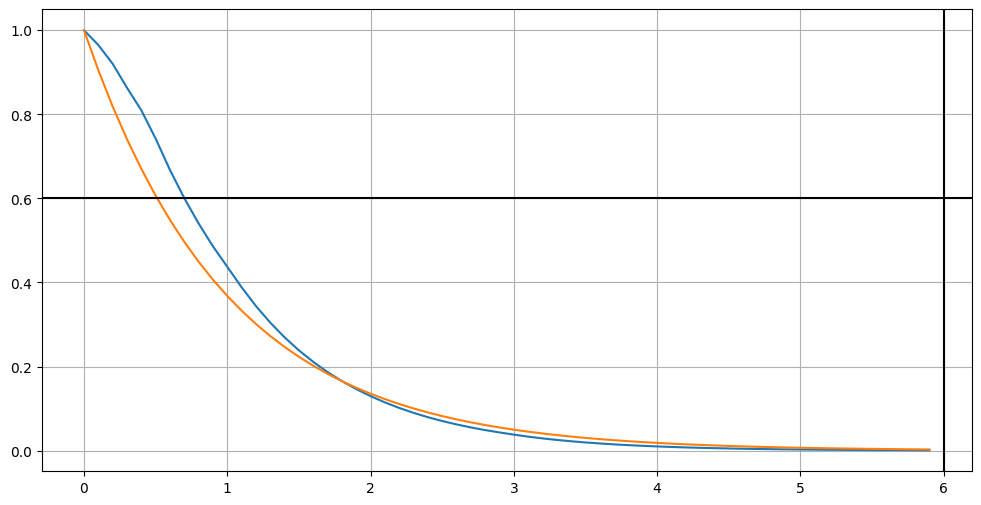

In [14]:
tv = np.arange(0, s_t[-1], 0.1)
S1v = S1(tv, sim_results["alpha_history"][-1], s_t)

alpha_xie = np.array([1, 1, 1, 1, 1, 1])
S1v_xie = S1(tv, alpha_xie, s_t)

print("alpha estimado: {}".format(sim_results["alpha_history"][-1]))
print("alpha xie: {}".format(alpha_xie))

fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(tv, S1v)
plt.plot(tv, S1v_xie)
plt.axhline(0.6, color = "black")
plt.axvline(6, color = "black")
plt.grid()
plt.show()

In [15]:
eta_pred_train = sim_results["new_model"].predict(file_info["img_train"])
eta_pred_test = sim_results["new_model"].predict(file_info["img_test"])

I0000 00:00:1740212563.980803  154031 service.cc:148] XLA service 0x7484ec0049e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740212563.981353  154031 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6


30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

I0000 00:00:1740212564.470737  154031 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [27]:
file_info["m_train"].to_numpy()[:20]

array([2, 1, 3, 2, 3, 0, 2, 2, 1, 3, 1, 2, 1, 3, 0, 0, 0, 3, 2, 0])

In [28]:
sim_results["m_history"][-1][:20]

array([1.73738731e+01, 1.48902365e+00, 2.58218390e+00, 3.68735088e+00,
       3.70881640e+01, 4.28572373e-03, 1.21238737e+00, 5.99913693e+00,
       8.05902156e-02, 6.13134760e+02, 3.66604930e+01, 3.87073192e+00,
       3.78994666e-01, 2.67260772e+01, 2.43132125e-03, 1.31500311e-04,
       9.13049455e-04, 2.64165462e+00, 2.48438429e+00, 1.25500221e-03])